<a href="https://colab.research.google.com/github/san0369/VLG_OPEN_PROJECT/blob/main/VLG_OP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install config

In [ ]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import os
# from keras.layers.wrappers import *
from config import *

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EURUSD_15m_BID_01.01.2010-31.12.2016.csv")
print(df.count())

Time      245444
Open      245444
High      245444
Low       245444
Close     245444
Volume    245444
dtype: int64


In [ ]:
df.rename(columns={'Time': 'timestamp', 'Open': 'open', 'Close': 'close',
                   'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.set_index('timestamp', inplace=True)
df = df.astype(float)

In [ ]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [ ]:
target_index = df.columns.tolist().index('close')
dataset = df.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset.shape)
dataset

(245444, 5)


array([[0.86802125, 0.86661553, 0.86945367, 0.8682153 , 0.01610139],
       [0.8680651 , 0.86665916, 0.8695631 , 0.86782193, 0.01417007],
       [0.8679559 , 0.8668339 , 0.8697822 , 0.8679528 , 0.01154295],
       ...,
       [0.03478622, 0.03325295, 0.03563118, 0.03474355, 0.        ],
       [0.03478622, 0.03325295, 0.03563118, 0.03474355, 0.        ],
       [0.03478622, 0.03325295, 0.03563118, 0.03474355, 0.        ]],
      dtype=float32)

In [ ]:
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)

X, y = create_dataset(dataset, look_back=30)
y = y[:, target_index]

In [ ]:
train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [ ]:
model = Sequential()

model.add(
    Bidirectional(LSTM(30, input_shape=(X.shape[1], X.shape[2]),
                       return_sequences=True),
                  merge_mode='sum',
                  weights=None,
                  input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 30, 30)            8640      
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 30, 10)            1640      
                                                                 
 dropout (Dropout)           (None, 30, 10)            0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 240       
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                        

In [ ]:
def train():
    # Save the best weight during training.
    checkpoint = ModelCheckpoint(bi_rnn_weights,
                                 monitor='val_mean_squared_error',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min')

    # Fit
    callbacks_list = [checkpoint]
    history = model.fit(trainX, trainY, epochs=200, batch_size=1024, verbose=1, callbacks=callbacks_list,
                        validation_split=0.1)

    epoch = len(history.history['loss'])

    # for k in list(history.history.keys()):
    #     if 'val' not in k:
    #         plt.figure(figsize=(40, 10))
    #         plt.plot(history.history[k])
    #         plt.plot(history.history['val_' + k])
    #         plt.title(k)
    #         plt.ylabel(k)
    #         plt.xlabel('epoch')
    #         plt.legend(['train', 'test'], loc='upper left')
    #         plt.show()
    model.save_weights(bi_rnn_weights)

    # Load the weight that worked the best
    model.load_weights(bi_rnn_weights)



In [ ]:
def scheduler(epoch):
        if epoch % 2 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * .9)
            print("lr changed to {}".format(lr * .9))
        return K.get_value(model.optimizer.lr)

checkpoint=[]
epoch=0
lr_decay = LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=int(min(epoch / 3, 5)), batch_size=500, verbose=1,
                        callbacks=callbacks_list,
                        validation_split=0.1)

In [ ]:
def benchmark():
    # Benchmark
    model.load_weights(bi_rnn_weights)

    pred = model.predict(testX)
    pred = y_scaler.inverse_transform(pred)
    close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))
    predictions = pd.DataFrame()
    predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
    predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

    p = df[-pred.shape[0]:].copy()
    predictions.index = p.index
    predictions = predictions.astype(float)

    predictions = predictions.merge(p[['low', 'high']], left_index=True, right_index=True)

    X=predictions.index.tolist()
    X = pd.to_datetime(X)
    y1 = predictions['close']
    y2 = predictions['predicted']
    y1 = y1.to_numpy()
    y2 = y2.to_numpy()

    plt.figure(figsize=(40, 20))
    ax = plt.plot(X, y1, c='blue',label = "Actual Data")
    ax = plt.plot(X, y2, c='red',label = "Predicted Data")

    index = [str(item) for item in predictions.index]
    plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
    plt.title('Prediction vs Actual')
    plt.xlabel('TimeFrames',fontsize=25)
    plt.ylabel('Forex Rate',fontsize=25)
    plt.legend(loc="upper right",fontsize=30)
    plt.savefig('LSTM_PRED.pdf')
    plt.show()

    predictions['diff'] = predictions['predicted'] - predictions['close']
    plt.figure(figsize=(10, 10))
    sns.distplot(predictions['diff']);
    plt.title('Distribution of differences between actual and prediction ')
    plt.savefig('LSTM_DIFF.pdf')
    plt.show()

    print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
    print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
    predictions['diff'].describe()

Epoch 1/200
210/214 [============================>.] - ETA: 0s - loss: 0.1756 - mae: 0.3527 - mse: 0.1756

214/214 [==============================] - 15s 20ms/step - loss: 0.1729 - mae: 0.3485 - mse: 0.1729 - val_loss: 0.0012 - val_mae: 0.0241 - val_mse: 0.0012
Epoch 2/200
210/214 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0410 - mse: 0.0045

214/214 [==============================] - 3s 12ms/step - loss: 0.0045 - mae: 0.0407 - mse: 0.0045 - val_loss: 1.6640e-04 - val_mae: 0.0108 - val_mse: 1.6640e-04
Epoch 3/200
212/214 [============================>.] - ETA: 0s - loss: 7.9998e-04 - mae: 0.0193 - mse: 7.9998e-04

214/214 [==============================] - 3s 12ms/step - loss: 7.9735e-04 - mae: 0.0192 - mse: 7.9735e-04 - val_loss: 3.8403e-05 - val_mae: 0.0045 - val_mse: 3.8403e-05
Epoch 4/200
213/214 [============================>.] - ETA: 0s - loss: 3.4092e-04 - mae: 0.0133 - mse: 3.4092e-04

214/214 [==============================] - 3s 14ms/step - loss: 3.4062e-04 - mae: 0.0133 - mse: 3.4062e-04 - val_loss: 2.7447e-05 - val_mae: 0.0038 - val_mse: 2.7447e-05
Epoch 5/200
212/214 [============================>.] - ETA: 0s - loss: 2.0885e-04 - mae: 0.0105 - mse: 2.0885e-04

214/214 [==============================] - 4s 17ms/step - loss: 2.0880e-04 - mae: 0.0105 - mse: 2.0880e-04 - val_loss: 4.0566e-05 - val_mae: 0.0050 - val_mse: 4.0566e-05
Epoch 6/200
212/214 [============================>.] - ETA: 0s - loss: 1.4906e-04 - mae: 0.0089 - mse: 1.4906e-04

214/214 [==============================] - 3s 12ms/step - loss: 1.4884e-04 - mae: 0.0089 - mse: 1.4884e-04 - val_loss: 9.8499e-05 - val_mae: 0.0090 - val_mse: 9.8499e-05
Epoch 7/200
210/214 [============================>.] - ETA: 0s - loss: 1.1468e-04 - mae: 0.0078 - mse: 1.1468e-04

214/214 [==============================] - 3s 12ms/step - loss: 1.1449e-04 - mae: 0.0078 - mse: 1.1449e-04 - val_loss: 2.6206e-05 - val_mae: 0.0041 - val_mse: 2.6206e-05
Epoch 8/200
214/214 [==============================] - ETA: 0s - loss: 9.4098e-05 - mae: 0.0071 - mse: 9.4098e-05

214/214 [==============================] - 3s 12ms/step - loss: 9.4098e-05 - mae: 0.0071 - mse: 9.4098e-05 - val_loss: 1.8737e-05 - val_mae: 0.0034 - val_mse: 1.8737e-05
Epoch 9/200
213/214 [============================>.] - ETA: 0s - loss: 8.0972e-05 - mae: 0.0066 - mse: 8.0972e-05

214/214 [==============================] - 3s 14ms/step - loss: 8.0939e-05 - mae: 0.0066 - mse: 8.0939e-05 - val_loss: 1.6195e-05 - val_mae: 0.0030 - val_mse: 1.6195e-05
Epoch 10/200
214/214 [==============================] - ETA: 0s - loss: 7.0993e-05 - mae: 0.0062 - mse: 7.0993e-05

214/214 [==============================] - 4s 17ms/step - loss: 7.0993e-05 - mae: 0.0062 - mse: 7.0993e-05 - val_loss: 1.3161e-05 - val_mae: 0.0025 - val_mse: 1.3161e-05
Epoch 11/200
213/214 [============================>.] - ETA: 0s - loss: 6.3713e-05 - mae: 0.0059 - mse: 6.3713e-05

214/214 [==============================] - 3s 12ms/step - loss: 6.3686e-05 - mae: 0.0059 - mse: 6.3686e-05 - val_loss: 1.2906e-05 - val_mae: 0.0025 - val_mse: 1.2906e-05
Epoch 12/200
212/214 [============================>.] - ETA: 0s - loss: 5.8693e-05 - mae: 0.0057 - mse: 5.8693e-05

214/214 [==============================] - 3s 12ms/step - loss: 5.8647e-05 - mae: 0.0057 - mse: 5.8647e-05 - val_loss: 1.6898e-05 - val_mae: 0.0031 - val_mse: 1.6898e-05
Epoch 13/200
211/214 [============================>.] - ETA: 0s - loss: 5.1322e-05 - mae: 0.0053 - mse: 5.1322e-05

214/214 [==============================] - 3s 13ms/step - loss: 5.1275e-05 - mae: 0.0053 - mse: 5.1275e-05 - val_loss: 3.2933e-05 - val_mae: 0.0049 - val_mse: 3.2933e-05
Epoch 14/200
213/214 [============================>.] - ETA: 0s - loss: 5.0468e-05 - mae: 0.0054 - mse: 5.0468e-05

214/214 [==============================] - 3s 15ms/step - loss: 5.0459e-05 - mae: 0.0054 - mse: 5.0459e-05 - val_loss: 2.7508e-05 - val_mae: 0.0044 - val_mse: 2.7508e-05
Epoch 15/200
214/214 [==============================] - ETA: 0s - loss: 4.5508e-05 - mae: 0.0051 - mse: 4.5508e-05

214/214 [==============================] - 4s 17ms/step - loss: 4.5508e-05 - mae: 0.0051 - mse: 4.5508e-05 - val_loss: 2.7392e-05 - val_mae: 0.0044 - val_mse: 2.7392e-05
Epoch 16/200
213/214 [============================>.] - ETA: 0s - loss: 4.4438e-05 - mae: 0.0050 - mse: 4.4438e-05

214/214 [==============================] - 4s 18ms/step - loss: 4.4420e-05 - mae: 0.0050 - mse: 4.4420e-05 - val_loss: 3.3626e-05 - val_mae: 0.0050 - val_mse: 3.3626e-05
Epoch 17/200
210/214 [============================>.] - ETA: 0s - loss: 4.0068e-05 - mae: 0.0048 - mse: 4.0068e-05

214/214 [==============================] - 3s 14ms/step - loss: 3.9964e-05 - mae: 0.0048 - mse: 3.9964e-05 - val_loss: 1.8061e-05 - val_mae: 0.0034 - val_mse: 1.8061e-05
Epoch 18/200
213/214 [============================>.] - ETA: 0s - loss: 3.9320e-05 - mae: 0.0047 - mse: 3.9320e-05

214/214 [==============================] - 3s 12ms/step - loss: 3.9311e-05 - mae: 0.0047 - mse: 3.9311e-05 - val_loss: 1.7340e-05 - val_mae: 0.0033 - val_mse: 1.7340e-05
Epoch 19/200
213/214 [============================>.] - ETA: 0s - loss: 3.6592e-05 - mae: 0.0045 - mse: 3.6592e-05

214/214 [==============================] - 4s 18ms/step - loss: 3.6604e-05 - mae: 0.0045 - mse: 3.6604e-05 - val_loss: 1.4814e-05 - val_mae: 0.0030 - val_mse: 1.4814e-05
Epoch 20/200
214/214 [==============================] - ETA: 0s - loss: 3.4588e-05 - mae: 0.0044 - mse: 3.4588e-05

214/214 [==============================] - 3s 13ms/step - loss: 3.4588e-05 - mae: 0.0044 - mse: 3.4588e-05 - val_loss: 4.0570e-05 - val_mae: 0.0057 - val_mse: 4.0570e-05
Epoch 21/200
214/214 [==============================] - ETA: 0s - loss: 3.4750e-05 - mae: 0.0044 - mse: 3.4750e-05

214/214 [==============================] - 3s 12ms/step - loss: 3.4750e-05 - mae: 0.0044 - mse: 3.4750e-05 - val_loss: 6.0733e-05 - val_mae: 0.0071 - val_mse: 6.0733e-05
Epoch 22/200
214/214 [==============================] - ETA: 0s - loss: 3.3188e-05 - mae: 0.0043 - mse: 3.3188e-05

214/214 [==============================] - 3s 12ms/step - loss: 3.3188e-05 - mae: 0.0043 - mse: 3.3188e-05 - val_loss: 1.3238e-05 - val_mae: 0.0028 - val_mse: 1.3238e-05
Epoch 23/200
212/214 [============================>.] - ETA: 0s - loss: 3.1319e-05 - mae: 0.0042 - mse: 3.1319e-05

214/214 [==============================] - 3s 12ms/step - loss: 3.1341e-05 - mae: 0.0042 - mse: 3.1341e-05 - val_loss: 1.3543e-05 - val_mae: 0.0027 - val_mse: 1.3543e-05
Epoch 24/200
214/214 [==============================] - ETA: 0s - loss: 3.0143e-05 - mae: 0.0041 - mse: 3.0143e-05

214/214 [==============================] - 4s 17ms/step - loss: 3.0143e-05 - mae: 0.0041 - mse: 3.0143e-05 - val_loss: 3.8492e-05 - val_mae: 0.0056 - val_mse: 3.8492e-05
Epoch 25/200
214/214 [==============================] - ETA: 0s - loss: 2.9399e-05 - mae: 0.0041 - mse: 2.9399e-05

214/214 [==============================] - 3s 14ms/step - loss: 2.9399e-05 - mae: 0.0041 - mse: 2.9399e-05 - val_loss: 1.9495e-05 - val_mae: 0.0037 - val_mse: 1.9495e-05
Epoch 26/200
211/214 [============================>.] - ETA: 0s - loss: 3.0070e-05 - mae: 0.0041 - mse: 3.0070e-05

214/214 [==============================] - 3s 13ms/step - loss: 3.0139e-05 - mae: 0.0042 - mse: 3.0139e-05 - val_loss: 1.3591e-05 - val_mae: 0.0026 - val_mse: 1.3591e-05
Epoch 27/200
212/214 [============================>.] - ETA: 0s - loss: 2.8121e-05 - mae: 0.0040 - mse: 2.8121e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.8108e-05 - mae: 0.0040 - mse: 2.8108e-05 - val_loss: 2.2784e-05 - val_mae: 0.0042 - val_mse: 2.2784e-05
Epoch 28/200
213/214 [============================>.] - ETA: 0s - loss: 2.8306e-05 - mae: 0.0040 - mse: 2.8306e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.8304e-05 - mae: 0.0040 - mse: 2.8304e-05 - val_loss: 2.9789e-05 - val_mae: 0.0048 - val_mse: 2.9789e-05
Epoch 29/200
213/214 [============================>.] - ETA: 0s - loss: 2.5807e-05 - mae: 0.0038 - mse: 2.5807e-05

214/214 [==============================] - 4s 19ms/step - loss: 2.5805e-05 - mae: 0.0038 - mse: 2.5805e-05 - val_loss: 1.2839e-05 - val_mae: 0.0026 - val_mse: 1.2839e-05
Epoch 30/200
211/214 [============================>.] - ETA: 0s - loss: 2.5180e-05 - mae: 0.0038 - mse: 2.5180e-05

214/214 [==============================] - 3s 14ms/step - loss: 2.5179e-05 - mae: 0.0038 - mse: 2.5179e-05 - val_loss: 1.4270e-05 - val_mae: 0.0025 - val_mse: 1.4270e-05
Epoch 31/200
212/214 [============================>.] - ETA: 0s - loss: 2.5122e-05 - mae: 0.0038 - mse: 2.5122e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.5092e-05 - mae: 0.0038 - mse: 2.5092e-05 - val_loss: 1.7436e-05 - val_mae: 0.0033 - val_mse: 1.7436e-05
Epoch 32/200
214/214 [==============================] - ETA: 0s - loss: 2.5168e-05 - mae: 0.0038 - mse: 2.5168e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.5168e-05 - mae: 0.0038 - mse: 2.5168e-05 - val_loss: 1.7538e-05 - val_mae: 0.0035 - val_mse: 1.7538e-05
Epoch 33/200
214/214 [==============================] - ETA: 0s - loss: 2.3867e-05 - mae: 0.0037 - mse: 2.3867e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.3867e-05 - mae: 0.0037 - mse: 2.3867e-05 - val_loss: 1.9257e-05 - val_mae: 0.0038 - val_mse: 1.9257e-05
Epoch 34/200
214/214 [==============================] - ETA: 0s - loss: 2.4923e-05 - mae: 0.0038 - mse: 2.4923e-05

214/214 [==============================] - 4s 17ms/step - loss: 2.4923e-05 - mae: 0.0038 - mse: 2.4923e-05 - val_loss: 1.7175e-05 - val_mae: 0.0025 - val_mse: 1.7175e-05
Epoch 35/200
212/214 [============================>.] - ETA: 0s - loss: 2.2161e-05 - mae: 0.0035 - mse: 2.2161e-05

214/214 [==============================] - 3s 16ms/step - loss: 2.2152e-05 - mae: 0.0035 - mse: 2.2152e-05 - val_loss: 1.9319e-05 - val_mae: 0.0027 - val_mse: 1.9319e-05
Epoch 36/200
214/214 [==============================] - ETA: 0s - loss: 2.2773e-05 - mae: 0.0036 - mse: 2.2773e-05

214/214 [==============================] - 3s 13ms/step - loss: 2.2773e-05 - mae: 0.0036 - mse: 2.2773e-05 - val_loss: 1.8689e-05 - val_mae: 0.0035 - val_mse: 1.8689e-05
Epoch 37/200
214/214 [==============================] - ETA: 0s - loss: 2.2101e-05 - mae: 0.0035 - mse: 2.2101e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.2101e-05 - mae: 0.0035 - mse: 2.2101e-05 - val_loss: 1.5179e-05 - val_mae: 0.0032 - val_mse: 1.5179e-05
Epoch 38/200
213/214 [============================>.] - ETA: 0s - loss: 2.2552e-05 - mae: 0.0036 - mse: 2.2552e-05

214/214 [==============================] - 3s 14ms/step - loss: 2.2554e-05 - mae: 0.0036 - mse: 2.2554e-05 - val_loss: 1.1479e-05 - val_mae: 0.0023 - val_mse: 1.1479e-05
Epoch 39/200
214/214 [==============================] - ETA: 0s - loss: 2.2187e-05 - mae: 0.0035 - mse: 2.2187e-05

214/214 [==============================] - 4s 16ms/step - loss: 2.2187e-05 - mae: 0.0035 - mse: 2.2187e-05 - val_loss: 1.3497e-05 - val_mae: 0.0023 - val_mse: 1.3497e-05
Epoch 40/200
213/214 [============================>.] - ETA: 0s - loss: 2.0376e-05 - mae: 0.0034 - mse: 2.0376e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.0368e-05 - mae: 0.0034 - mse: 2.0368e-05 - val_loss: 1.2698e-05 - val_mae: 0.0023 - val_mse: 1.2698e-05
Epoch 41/200
210/214 [============================>.] - ETA: 0s - loss: 2.0341e-05 - mae: 0.0034 - mse: 2.0341e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.0493e-05 - mae: 0.0034 - mse: 2.0493e-05 - val_loss: 1.1307e-05 - val_mae: 0.0024 - val_mse: 1.1307e-05
Epoch 42/200
214/214 [==============================] - ETA: 0s - loss: 2.1314e-05 - mae: 0.0035 - mse: 2.1314e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.1314e-05 - mae: 0.0035 - mse: 2.1314e-05 - val_loss: 1.1971e-05 - val_mae: 0.0023 - val_mse: 1.1971e-05
Epoch 43/200
213/214 [============================>.] - ETA: 0s - loss: 2.0057e-05 - mae: 0.0034 - mse: 2.0057e-05

214/214 [==============================] - 3s 12ms/step - loss: 2.0052e-05 - mae: 0.0034 - mse: 2.0052e-05 - val_loss: 1.2864e-05 - val_mae: 0.0025 - val_mse: 1.2864e-05
Epoch 44/200
214/214 [==============================] - ETA: 0s - loss: 1.8981e-05 - mae: 0.0033 - mse: 1.8981e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.8981e-05 - mae: 0.0033 - mse: 1.8981e-05 - val_loss: 1.5507e-05 - val_mae: 0.0026 - val_mse: 1.5507e-05
Epoch 45/200
210/214 [============================>.] - ETA: 0s - loss: 1.9145e-05 - mae: 0.0033 - mse: 1.9145e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.9189e-05 - mae: 0.0033 - mse: 1.9189e-05 - val_loss: 1.8249e-05 - val_mae: 0.0035 - val_mse: 1.8249e-05
Epoch 46/200
212/214 [============================>.] - ETA: 0s - loss: 1.9926e-05 - mae: 0.0034 - mse: 1.9926e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.9915e-05 - mae: 0.0034 - mse: 1.9915e-05 - val_loss: 1.1602e-05 - val_mae: 0.0021 - val_mse: 1.1602e-05
Epoch 47/200
212/214 [============================>.] - ETA: 0s - loss: 1.7961e-05 - mae: 0.0032 - mse: 1.7961e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.7965e-05 - mae: 0.0032 - mse: 1.7965e-05 - val_loss: 1.6384e-05 - val_mae: 0.0035 - val_mse: 1.6384e-05
Epoch 48/200
213/214 [============================>.] - ETA: 0s - loss: 1.8336e-05 - mae: 0.0032 - mse: 1.8336e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.8351e-05 - mae: 0.0032 - mse: 1.8351e-05 - val_loss: 1.1496e-05 - val_mae: 0.0020 - val_mse: 1.1496e-05
Epoch 49/200
213/214 [============================>.] - ETA: 0s - loss: 1.7750e-05 - mae: 0.0032 - mse: 1.7750e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.7747e-05 - mae: 0.0032 - mse: 1.7747e-05 - val_loss: 1.3549e-05 - val_mae: 0.0030 - val_mse: 1.3549e-05
Epoch 50/200
213/214 [============================>.] - ETA: 0s - loss: 1.8337e-05 - mae: 0.0032 - mse: 1.8337e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.8325e-05 - mae: 0.0032 - mse: 1.8325e-05 - val_loss: 1.9790e-05 - val_mae: 0.0039 - val_mse: 1.9790e-05
Epoch 51/200
211/214 [============================>.] - ETA: 0s - loss: 1.9357e-05 - mae: 0.0033 - mse: 1.9357e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.9313e-05 - mae: 0.0033 - mse: 1.9313e-05 - val_loss: 1.8672e-05 - val_mae: 0.0037 - val_mse: 1.8672e-05
Epoch 52/200
213/214 [============================>.] - ETA: 0s - loss: 1.6817e-05 - mae: 0.0031 - mse: 1.6817e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.6817e-05 - mae: 0.0031 - mse: 1.6817e-05 - val_loss: 9.8029e-06 - val_mae: 0.0019 - val_mse: 9.8029e-06
Epoch 53/200
213/214 [============================>.] - ETA: 0s - loss: 1.7237e-05 - mae: 0.0031 - mse: 1.7237e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.7237e-05 - mae: 0.0031 - mse: 1.7237e-05 - val_loss: 1.1629e-05 - val_mae: 0.0021 - val_mse: 1.1629e-05
Epoch 54/200
212/214 [============================>.] - ETA: 0s - loss: 1.7377e-05 - mae: 0.0031 - mse: 1.7377e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.7353e-05 - mae: 0.0031 - mse: 1.7353e-05 - val_loss: 1.2556e-05 - val_mae: 0.0028 - val_mse: 1.2556e-05
Epoch 55/200
210/214 [============================>.] - ETA: 0s - loss: 1.6019e-05 - mae: 0.0030 - mse: 1.6019e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.6039e-05 - mae: 0.0030 - mse: 1.6039e-05 - val_loss: 1.3923e-05 - val_mae: 0.0025 - val_mse: 1.3923e-05
Epoch 56/200
213/214 [============================>.] - ETA: 0s - loss: 1.7332e-05 - mae: 0.0031 - mse: 1.7332e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.7362e-05 - mae: 0.0031 - mse: 1.7362e-05 - val_loss: 1.7428e-05 - val_mae: 0.0030 - val_mse: 1.7428e-05
Epoch 57/200
211/214 [============================>.] - ETA: 0s - loss: 1.5983e-05 - mae: 0.0030 - mse: 1.5983e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.6002e-05 - mae: 0.0030 - mse: 1.6002e-05 - val_loss: 1.0818e-05 - val_mae: 0.0026 - val_mse: 1.0818e-05
Epoch 58/200
214/214 [==============================] - ETA: 0s - loss: 1.6686e-05 - mae: 0.0031 - mse: 1.6686e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.6686e-05 - mae: 0.0031 - mse: 1.6686e-05 - val_loss: 1.4594e-05 - val_mae: 0.0034 - val_mse: 1.4594e-05
Epoch 59/200
212/214 [============================>.] - ETA: 0s - loss: 1.6036e-05 - mae: 0.0030 - mse: 1.6036e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.6020e-05 - mae: 0.0030 - mse: 1.6020e-05 - val_loss: 1.1166e-05 - val_mae: 0.0019 - val_mse: 1.1166e-05
Epoch 60/200
211/214 [============================>.] - ETA: 0s - loss: 1.5892e-05 - mae: 0.0030 - mse: 1.5892e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.5880e-05 - mae: 0.0030 - mse: 1.5880e-05 - val_loss: 1.2749e-05 - val_mae: 0.0029 - val_mse: 1.2749e-05
Epoch 61/200
213/214 [============================>.] - ETA: 0s - loss: 1.7051e-05 - mae: 0.0031 - mse: 1.7051e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.7048e-05 - mae: 0.0031 - mse: 1.7048e-05 - val_loss: 1.0150e-05 - val_mae: 0.0024 - val_mse: 1.0150e-05
Epoch 62/200
213/214 [============================>.] - ETA: 0s - loss: 1.5145e-05 - mae: 0.0029 - mse: 1.5145e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.5139e-05 - mae: 0.0029 - mse: 1.5139e-05 - val_loss: 1.6567e-05 - val_mae: 0.0036 - val_mse: 1.6567e-05
Epoch 63/200
214/214 [==============================] - ETA: 0s - loss: 1.6121e-05 - mae: 0.0030 - mse: 1.6121e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.6121e-05 - mae: 0.0030 - mse: 1.6121e-05 - val_loss: 9.8119e-06 - val_mae: 0.0021 - val_mse: 9.8119e-06
Epoch 64/200
214/214 [==============================] - ETA: 0s - loss: 1.4911e-05 - mae: 0.0029 - mse: 1.4911e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.4911e-05 - mae: 0.0029 - mse: 1.4911e-05 - val_loss: 1.5104e-05 - val_mae: 0.0034 - val_mse: 1.5104e-05
Epoch 65/200
214/214 [==============================] - ETA: 0s - loss: 1.5215e-05 - mae: 0.0029 - mse: 1.5215e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.5215e-05 - mae: 0.0029 - mse: 1.5215e-05 - val_loss: 1.0126e-05 - val_mae: 0.0025 - val_mse: 1.0126e-05
Epoch 66/200
213/214 [============================>.] - ETA: 0s - loss: 1.4468e-05 - mae: 0.0028 - mse: 1.4468e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.4466e-05 - mae: 0.0028 - mse: 1.4466e-05 - val_loss: 1.3492e-05 - val_mae: 0.0032 - val_mse: 1.3492e-05
Epoch 67/200
214/214 [==============================] - ETA: 0s - loss: 1.4861e-05 - mae: 0.0029 - mse: 1.4861e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.4861e-05 - mae: 0.0029 - mse: 1.4861e-05 - val_loss: 1.0720e-05 - val_mae: 0.0019 - val_mse: 1.0720e-05
Epoch 68/200
213/214 [============================>.] - ETA: 0s - loss: 1.4550e-05 - mae: 0.0029 - mse: 1.4550e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.4545e-05 - mae: 0.0029 - mse: 1.4545e-05 - val_loss: 8.4732e-06 - val_mae: 0.0023 - val_mse: 8.4732e-06
Epoch 69/200
213/214 [============================>.] - ETA: 0s - loss: 1.4701e-05 - mae: 0.0029 - mse: 1.4701e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.4694e-05 - mae: 0.0029 - mse: 1.4694e-05 - val_loss: 7.3458e-06 - val_mae: 0.0018 - val_mse: 7.3458e-06
Epoch 70/200
213/214 [============================>.] - ETA: 0s - loss: 1.4145e-05 - mae: 0.0028 - mse: 1.4145e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.4140e-05 - mae: 0.0028 - mse: 1.4140e-05 - val_loss: 8.4907e-06 - val_mae: 0.0024 - val_mse: 8.4907e-06
Epoch 71/200
213/214 [============================>.] - ETA: 0s - loss: 1.4325e-05 - mae: 0.0028 - mse: 1.4325e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.4330e-05 - mae: 0.0028 - mse: 1.4330e-05 - val_loss: 8.1676e-06 - val_mae: 0.0020 - val_mse: 8.1676e-06
Epoch 72/200
214/214 [==============================] - ETA: 0s - loss: 1.3638e-05 - mae: 0.0028 - mse: 1.3638e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.3638e-05 - mae: 0.0028 - mse: 1.3638e-05 - val_loss: 1.3578e-05 - val_mae: 0.0028 - val_mse: 1.3578e-05
Epoch 73/200
214/214 [==============================] - ETA: 0s - loss: 1.3862e-05 - mae: 0.0028 - mse: 1.3862e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.3862e-05 - mae: 0.0028 - mse: 1.3862e-05 - val_loss: 6.1394e-06 - val_mae: 0.0018 - val_mse: 6.1394e-06
Epoch 74/200
212/214 [============================>.] - ETA: 0s - loss: 1.3359e-05 - mae: 0.0027 - mse: 1.3359e-05

214/214 [==============================] - 4s 16ms/step - loss: 1.3353e-05 - mae: 0.0027 - mse: 1.3353e-05 - val_loss: 6.8602e-06 - val_mae: 0.0020 - val_mse: 6.8602e-06
Epoch 75/200
211/214 [============================>.] - ETA: 0s - loss: 1.5278e-05 - mae: 0.0029 - mse: 1.5278e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.5231e-05 - mae: 0.0029 - mse: 1.5231e-05 - val_loss: 9.5450e-06 - val_mae: 0.0026 - val_mse: 9.5450e-06
Epoch 76/200
210/214 [============================>.] - ETA: 0s - loss: 1.2448e-05 - mae: 0.0026 - mse: 1.2448e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.2426e-05 - mae: 0.0026 - mse: 1.2426e-05 - val_loss: 5.7808e-06 - val_mae: 0.0015 - val_mse: 5.7808e-06
Epoch 77/200
214/214 [==============================] - ETA: 0s - loss: 1.3167e-05 - mae: 0.0027 - mse: 1.3167e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.3167e-05 - mae: 0.0027 - mse: 1.3167e-05 - val_loss: 5.9319e-06 - val_mae: 0.0016 - val_mse: 5.9319e-06
Epoch 78/200
214/214 [==============================] - ETA: 0s - loss: 1.3341e-05 - mae: 0.0027 - mse: 1.3341e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.3341e-05 - mae: 0.0027 - mse: 1.3341e-05 - val_loss: 7.1589e-06 - val_mae: 0.0022 - val_mse: 7.1589e-06
Epoch 79/200
213/214 [============================>.] - ETA: 0s - loss: 1.3101e-05 - mae: 0.0027 - mse: 1.3101e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.3098e-05 - mae: 0.0027 - mse: 1.3098e-05 - val_loss: 8.1389e-06 - val_mae: 0.0022 - val_mse: 8.1389e-06
Epoch 80/200
213/214 [============================>.] - ETA: 0s - loss: 1.2652e-05 - mae: 0.0026 - mse: 1.2652e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.2657e-05 - mae: 0.0026 - mse: 1.2657e-05 - val_loss: 5.7281e-06 - val_mae: 0.0014 - val_mse: 5.7281e-06
Epoch 81/200
213/214 [============================>.] - ETA: 0s - loss: 1.3091e-05 - mae: 0.0027 - mse: 1.3091e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.3097e-05 - mae: 0.0027 - mse: 1.3097e-05 - val_loss: 7.1923e-06 - val_mae: 0.0021 - val_mse: 7.1923e-06
Epoch 82/200
211/214 [============================>.] - ETA: 0s - loss: 1.2513e-05 - mae: 0.0026 - mse: 1.2513e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.2506e-05 - mae: 0.0026 - mse: 1.2506e-05 - val_loss: 1.3743e-05 - val_mae: 0.0033 - val_mse: 1.3743e-05
Epoch 83/200
213/214 [============================>.] - ETA: 0s - loss: 1.3024e-05 - mae: 0.0027 - mse: 1.3024e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.3029e-05 - mae: 0.0027 - mse: 1.3029e-05 - val_loss: 1.2687e-05 - val_mae: 0.0032 - val_mse: 1.2687e-05
Epoch 84/200
211/214 [============================>.] - ETA: 0s - loss: 1.2012e-05 - mae: 0.0026 - mse: 1.2012e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.2017e-05 - mae: 0.0026 - mse: 1.2017e-05 - val_loss: 1.0265e-05 - val_mae: 0.0027 - val_mse: 1.0265e-05
Epoch 85/200
214/214 [==============================] - ETA: 0s - loss: 1.2241e-05 - mae: 0.0026 - mse: 1.2241e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.2241e-05 - mae: 0.0026 - mse: 1.2241e-05 - val_loss: 6.3240e-06 - val_mae: 0.0019 - val_mse: 6.3240e-06
Epoch 86/200
212/214 [============================>.] - ETA: 0s - loss: 1.2415e-05 - mae: 0.0026 - mse: 1.2415e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.2482e-05 - mae: 0.0026 - mse: 1.2482e-05 - val_loss: 8.1420e-06 - val_mae: 0.0023 - val_mse: 8.1420e-06
Epoch 87/200
213/214 [============================>.] - ETA: 0s - loss: 1.1723e-05 - mae: 0.0025 - mse: 1.1723e-05

214/214 [==============================] - 3s 15ms/step - loss: 1.1716e-05 - mae: 0.0025 - mse: 1.1716e-05 - val_loss: 9.0650e-06 - val_mae: 0.0025 - val_mse: 9.0650e-06
Epoch 88/200
211/214 [============================>.] - ETA: 0s - loss: 1.2432e-05 - mae: 0.0026 - mse: 1.2432e-05

214/214 [==============================] - 4s 19ms/step - loss: 1.2457e-05 - mae: 0.0026 - mse: 1.2457e-05 - val_loss: 6.9144e-06 - val_mae: 0.0020 - val_mse: 6.9144e-06
Epoch 89/200
212/214 [============================>.] - ETA: 0s - loss: 1.1288e-05 - mae: 0.0025 - mse: 1.1288e-05

214/214 [==============================] - 3s 16ms/step - loss: 1.1283e-05 - mae: 0.0025 - mse: 1.1283e-05 - val_loss: 1.4280e-05 - val_mae: 0.0033 - val_mse: 1.4280e-05
Epoch 90/200
212/214 [============================>.] - ETA: 0s - loss: 1.0903e-05 - mae: 0.0024 - mse: 1.0903e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.0894e-05 - mae: 0.0024 - mse: 1.0894e-05 - val_loss: 5.5088e-06 - val_mae: 0.0016 - val_mse: 5.5088e-06
Epoch 91/200
214/214 [==============================] - ETA: 0s - loss: 1.2183e-05 - mae: 0.0026 - mse: 1.2183e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.2183e-05 - mae: 0.0026 - mse: 1.2183e-05 - val_loss: 9.8584e-06 - val_mae: 0.0027 - val_mse: 9.8584e-06
Epoch 92/200
214/214 [==============================] - ETA: 0s - loss: 1.1555e-05 - mae: 0.0025 - mse: 1.1555e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.1555e-05 - mae: 0.0025 - mse: 1.1555e-05 - val_loss: 5.2104e-06 - val_mae: 0.0015 - val_mse: 5.2104e-06
Epoch 93/200
212/214 [============================>.] - ETA: 0s - loss: 1.1094e-05 - mae: 0.0025 - mse: 1.1094e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.1093e-05 - mae: 0.0025 - mse: 1.1093e-05 - val_loss: 6.3748e-06 - val_mae: 0.0015 - val_mse: 6.3748e-06
Epoch 94/200
212/214 [============================>.] - ETA: 0s - loss: 1.1389e-05 - mae: 0.0025 - mse: 1.1389e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.1391e-05 - mae: 0.0025 - mse: 1.1391e-05 - val_loss: 5.8143e-06 - val_mae: 0.0014 - val_mse: 5.8143e-06
Epoch 95/200
211/214 [============================>.] - ETA: 0s - loss: 1.1197e-05 - mae: 0.0025 - mse: 1.1197e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.1177e-05 - mae: 0.0025 - mse: 1.1177e-05 - val_loss: 4.5138e-06 - val_mae: 0.0014 - val_mse: 4.5138e-06
Epoch 96/200
214/214 [==============================] - ETA: 0s - loss: 1.1391e-05 - mae: 0.0025 - mse: 1.1391e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.1391e-05 - mae: 0.0025 - mse: 1.1391e-05 - val_loss: 5.8919e-06 - val_mae: 0.0015 - val_mse: 5.8919e-06
Epoch 97/200
214/214 [==============================] - ETA: 0s - loss: 1.1124e-05 - mae: 0.0025 - mse: 1.1124e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.1124e-05 - mae: 0.0025 - mse: 1.1124e-05 - val_loss: 5.5912e-06 - val_mae: 0.0015 - val_mse: 5.5912e-06
Epoch 98/200
213/214 [============================>.] - ETA: 0s - loss: 1.0705e-05 - mae: 0.0024 - mse: 1.0705e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.0697e-05 - mae: 0.0024 - mse: 1.0697e-05 - val_loss: 4.4707e-06 - val_mae: 0.0014 - val_mse: 4.4707e-06
Epoch 99/200
212/214 [============================>.] - ETA: 0s - loss: 1.1064e-05 - mae: 0.0025 - mse: 1.1064e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.1077e-05 - mae: 0.0025 - mse: 1.1077e-05 - val_loss: 1.0925e-05 - val_mae: 0.0028 - val_mse: 1.0925e-05
Epoch 100/200
213/214 [============================>.] - ETA: 0s - loss: 1.0287e-05 - mae: 0.0024 - mse: 1.0287e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.0286e-05 - mae: 0.0024 - mse: 1.0286e-05 - val_loss: 5.1942e-06 - val_mae: 0.0016 - val_mse: 5.1942e-06
Epoch 101/200
212/214 [============================>.] - ETA: 0s - loss: 1.0461e-05 - mae: 0.0024 - mse: 1.0461e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.0469e-05 - mae: 0.0024 - mse: 1.0469e-05 - val_loss: 5.5381e-06 - val_mae: 0.0018 - val_mse: 5.5381e-06
Epoch 102/200
212/214 [============================>.] - ETA: 0s - loss: 1.0519e-05 - mae: 0.0024 - mse: 1.0519e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.0505e-05 - mae: 0.0024 - mse: 1.0505e-05 - val_loss: 6.8172e-06 - val_mae: 0.0020 - val_mse: 6.8172e-06
Epoch 103/200
212/214 [============================>.] - ETA: 0s - loss: 1.0551e-05 - mae: 0.0024 - mse: 1.0551e-05

214/214 [==============================] - 3s 14ms/step - loss: 1.0538e-05 - mae: 0.0024 - mse: 1.0538e-05 - val_loss: 8.0954e-06 - val_mae: 0.0023 - val_mse: 8.0954e-06
Epoch 104/200
213/214 [============================>.] - ETA: 0s - loss: 1.0579e-05 - mae: 0.0024 - mse: 1.0579e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.0580e-05 - mae: 0.0024 - mse: 1.0580e-05 - val_loss: 7.4722e-06 - val_mae: 0.0022 - val_mse: 7.4722e-06
Epoch 105/200
212/214 [============================>.] - ETA: 0s - loss: 9.9347e-06 - mae: 0.0023 - mse: 9.9347e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.9412e-06 - mae: 0.0023 - mse: 9.9412e-06 - val_loss: 4.4987e-06 - val_mae: 0.0014 - val_mse: 4.4987e-06
Epoch 106/200
212/214 [============================>.] - ETA: 0s - loss: 1.1258e-05 - mae: 0.0025 - mse: 1.1258e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.1240e-05 - mae: 0.0025 - mse: 1.1240e-05 - val_loss: 6.8508e-06 - val_mae: 0.0019 - val_mse: 6.8508e-06
Epoch 107/200
213/214 [============================>.] - ETA: 0s - loss: 9.8418e-06 - mae: 0.0023 - mse: 9.8418e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.8624e-06 - mae: 0.0023 - mse: 9.8624e-06 - val_loss: 8.7401e-06 - val_mae: 0.0025 - val_mse: 8.7401e-06
Epoch 108/200
214/214 [==============================] - ETA: 0s - loss: 1.0175e-05 - mae: 0.0024 - mse: 1.0175e-05

214/214 [==============================] - 3s 15ms/step - loss: 1.0175e-05 - mae: 0.0024 - mse: 1.0175e-05 - val_loss: 8.3783e-06 - val_mae: 0.0024 - val_mse: 8.3783e-06
Epoch 109/200
212/214 [============================>.] - ETA: 0s - loss: 9.8512e-06 - mae: 0.0023 - mse: 9.8512e-06

214/214 [==============================] - 4s 17ms/step - loss: 9.8650e-06 - mae: 0.0023 - mse: 9.8650e-06 - val_loss: 9.7113e-06 - val_mae: 0.0026 - val_mse: 9.7113e-06
Epoch 110/200
212/214 [============================>.] - ETA: 0s - loss: 1.0084e-05 - mae: 0.0024 - mse: 1.0084e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.0107e-05 - mae: 0.0024 - mse: 1.0107e-05 - val_loss: 5.3888e-06 - val_mae: 0.0014 - val_mse: 5.3888e-06
Epoch 111/200
212/214 [============================>.] - ETA: 0s - loss: 1.0281e-05 - mae: 0.0024 - mse: 1.0281e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.0274e-05 - mae: 0.0024 - mse: 1.0274e-05 - val_loss: 5.3991e-06 - val_mae: 0.0017 - val_mse: 5.3991e-06
Epoch 112/200
212/214 [============================>.] - ETA: 0s - loss: 1.0137e-05 - mae: 0.0024 - mse: 1.0137e-05

214/214 [==============================] - 3s 12ms/step - loss: 1.0126e-05 - mae: 0.0024 - mse: 1.0126e-05 - val_loss: 6.1625e-06 - val_mae: 0.0019 - val_mse: 6.1625e-06
Epoch 113/200
214/214 [==============================] - ETA: 0s - loss: 9.6194e-06 - mae: 0.0023 - mse: 9.6194e-06

214/214 [==============================] - 3s 13ms/step - loss: 9.6194e-06 - mae: 0.0023 - mse: 9.6194e-06 - val_loss: 4.9051e-06 - val_mae: 0.0015 - val_mse: 4.9051e-06
Epoch 114/200
212/214 [============================>.] - ETA: 0s - loss: 1.0145e-05 - mae: 0.0024 - mse: 1.0145e-05

214/214 [==============================] - 4s 17ms/step - loss: 1.0142e-05 - mae: 0.0024 - mse: 1.0142e-05 - val_loss: 5.5957e-06 - val_mae: 0.0014 - val_mse: 5.5957e-06
Epoch 115/200
211/214 [============================>.] - ETA: 0s - loss: 9.1001e-06 - mae: 0.0022 - mse: 9.1001e-06

214/214 [==============================] - 3s 13ms/step - loss: 9.0959e-06 - mae: 0.0022 - mse: 9.0959e-06 - val_loss: 4.7856e-06 - val_mae: 0.0014 - val_mse: 4.7856e-06
Epoch 116/200
212/214 [============================>.] - ETA: 0s - loss: 9.6617e-06 - mae: 0.0023 - mse: 9.6617e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.6550e-06 - mae: 0.0023 - mse: 9.6550e-06 - val_loss: 4.9775e-06 - val_mae: 0.0014 - val_mse: 4.9775e-06
Epoch 117/200
213/214 [============================>.] - ETA: 0s - loss: 9.7494e-06 - mae: 0.0023 - mse: 9.7494e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.7446e-06 - mae: 0.0023 - mse: 9.7446e-06 - val_loss: 4.9806e-06 - val_mae: 0.0014 - val_mse: 4.9806e-06
Epoch 118/200
213/214 [============================>.] - ETA: 0s - loss: 1.0070e-05 - mae: 0.0024 - mse: 1.0070e-05

214/214 [==============================] - 3s 13ms/step - loss: 1.0070e-05 - mae: 0.0024 - mse: 1.0070e-05 - val_loss: 1.0018e-05 - val_mae: 0.0027 - val_mse: 1.0018e-05
Epoch 119/200
212/214 [============================>.] - ETA: 0s - loss: 9.1621e-06 - mae: 0.0022 - mse: 9.1621e-06

214/214 [==============================] - 4s 18ms/step - loss: 9.1597e-06 - mae: 0.0022 - mse: 9.1597e-06 - val_loss: 4.3858e-06 - val_mae: 0.0013 - val_mse: 4.3858e-06
Epoch 120/200
211/214 [============================>.] - ETA: 0s - loss: 9.4754e-06 - mae: 0.0023 - mse: 9.4754e-06

214/214 [==============================] - 3s 13ms/step - loss: 9.4819e-06 - mae: 0.0023 - mse: 9.4819e-06 - val_loss: 6.1020e-06 - val_mae: 0.0015 - val_mse: 6.1020e-06
Epoch 121/200
210/214 [============================>.] - ETA: 0s - loss: 9.7222e-06 - mae: 0.0023 - mse: 9.7222e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.7165e-06 - mae: 0.0023 - mse: 9.7165e-06 - val_loss: 4.8085e-06 - val_mae: 0.0015 - val_mse: 4.8085e-06
Epoch 122/200
213/214 [============================>.] - ETA: 0s - loss: 8.9697e-06 - mae: 0.0022 - mse: 8.9697e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.9667e-06 - mae: 0.0022 - mse: 8.9667e-06 - val_loss: 4.5351e-06 - val_mae: 0.0013 - val_mse: 4.5351e-06
Epoch 123/200
212/214 [============================>.] - ETA: 0s - loss: 8.9778e-06 - mae: 0.0022 - mse: 8.9778e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.9970e-06 - mae: 0.0022 - mse: 8.9970e-06 - val_loss: 4.0705e-06 - val_mae: 0.0012 - val_mse: 4.0705e-06
Epoch 124/200
212/214 [============================>.] - ETA: 0s - loss: 9.3255e-06 - mae: 0.0023 - mse: 9.3255e-06

214/214 [==============================] - 4s 17ms/step - loss: 9.3158e-06 - mae: 0.0022 - mse: 9.3158e-06 - val_loss: 5.2842e-06 - val_mae: 0.0014 - val_mse: 5.2842e-06
Epoch 125/200
213/214 [============================>.] - ETA: 0s - loss: 9.1110e-06 - mae: 0.0022 - mse: 9.1110e-06

214/214 [==============================] - 3s 13ms/step - loss: 9.1107e-06 - mae: 0.0022 - mse: 9.1107e-06 - val_loss: 9.0541e-06 - val_mae: 0.0025 - val_mse: 9.0541e-06
Epoch 126/200
214/214 [==============================] - ETA: 0s - loss: 8.7192e-06 - mae: 0.0022 - mse: 8.7192e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.7192e-06 - mae: 0.0022 - mse: 8.7192e-06 - val_loss: 5.2109e-06 - val_mae: 0.0016 - val_mse: 5.2109e-06
Epoch 127/200
213/214 [============================>.] - ETA: 0s - loss: 9.0520e-06 - mae: 0.0022 - mse: 9.0520e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.0561e-06 - mae: 0.0022 - mse: 9.0561e-06 - val_loss: 8.3405e-06 - val_mae: 0.0024 - val_mse: 8.3405e-06
Epoch 128/200
213/214 [============================>.] - ETA: 0s - loss: 9.0556e-06 - mae: 0.0022 - mse: 9.0556e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.0711e-06 - mae: 0.0022 - mse: 9.0711e-06 - val_loss: 6.7609e-06 - val_mae: 0.0021 - val_mse: 6.7609e-06
Epoch 129/200
213/214 [============================>.] - ETA: 0s - loss: 9.1918e-06 - mae: 0.0022 - mse: 9.1918e-06

214/214 [==============================] - 4s 18ms/step - loss: 9.1936e-06 - mae: 0.0022 - mse: 9.1936e-06 - val_loss: 7.3167e-06 - val_mae: 0.0023 - val_mse: 7.3167e-06
Epoch 130/200
212/214 [============================>.] - ETA: 0s - loss: 8.8882e-06 - mae: 0.0022 - mse: 8.8882e-06

214/214 [==============================] - 3s 13ms/step - loss: 8.8834e-06 - mae: 0.0022 - mse: 8.8834e-06 - val_loss: 5.3365e-06 - val_mae: 0.0015 - val_mse: 5.3365e-06
Epoch 131/200
211/214 [============================>.] - ETA: 0s - loss: 9.2630e-06 - mae: 0.0023 - mse: 9.2630e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.2486e-06 - mae: 0.0023 - mse: 9.2486e-06 - val_loss: 6.4645e-06 - val_mae: 0.0016 - val_mse: 6.4645e-06
Epoch 132/200
212/214 [============================>.] - ETA: 0s - loss: 8.7699e-06 - mae: 0.0022 - mse: 8.7699e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.7671e-06 - mae: 0.0022 - mse: 8.7671e-06 - val_loss: 7.4665e-06 - val_mae: 0.0023 - val_mse: 7.4665e-06
Epoch 133/200
214/214 [==============================] - ETA: 0s - loss: 9.0765e-06 - mae: 0.0022 - mse: 9.0765e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.0765e-06 - mae: 0.0022 - mse: 9.0765e-06 - val_loss: 9.8983e-06 - val_mae: 0.0027 - val_mse: 9.8983e-06
Epoch 134/200
212/214 [============================>.] - ETA: 0s - loss: 8.9277e-06 - mae: 0.0022 - mse: 8.9277e-06

214/214 [==============================] - 3s 16ms/step - loss: 8.9222e-06 - mae: 0.0022 - mse: 8.9222e-06 - val_loss: 6.6993e-06 - val_mae: 0.0020 - val_mse: 6.6993e-06
Epoch 135/200
214/214 [==============================] - ETA: 0s - loss: 8.4014e-06 - mae: 0.0021 - mse: 8.4014e-06

214/214 [==============================] - 3s 14ms/step - loss: 8.4014e-06 - mae: 0.0021 - mse: 8.4014e-06 - val_loss: 5.5024e-06 - val_mae: 0.0016 - val_mse: 5.5024e-06
Epoch 136/200
212/214 [============================>.] - ETA: 0s - loss: 8.5121e-06 - mae: 0.0021 - mse: 8.5121e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.5243e-06 - mae: 0.0021 - mse: 8.5243e-06 - val_loss: 7.9837e-06 - val_mae: 0.0023 - val_mse: 7.9837e-06
Epoch 137/200
213/214 [============================>.] - ETA: 0s - loss: 8.7169e-06 - mae: 0.0022 - mse: 8.7169e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.7114e-06 - mae: 0.0022 - mse: 8.7114e-06 - val_loss: 5.6478e-06 - val_mae: 0.0019 - val_mse: 5.6478e-06
Epoch 138/200
211/214 [============================>.] - ETA: 0s - loss: 9.2672e-06 - mae: 0.0023 - mse: 9.2672e-06

214/214 [==============================] - 3s 13ms/step - loss: 9.2523e-06 - mae: 0.0023 - mse: 9.2523e-06 - val_loss: 8.5604e-06 - val_mae: 0.0025 - val_mse: 8.5604e-06
Epoch 139/200
211/214 [============================>.] - ETA: 0s - loss: 7.9104e-06 - mae: 0.0020 - mse: 7.9104e-06

214/214 [==============================] - 3s 16ms/step - loss: 7.9060e-06 - mae: 0.0020 - mse: 7.9060e-06 - val_loss: 5.3703e-06 - val_mae: 0.0017 - val_mse: 5.3703e-06
Epoch 140/200
212/214 [============================>.] - ETA: 0s - loss: 8.5111e-06 - mae: 0.0021 - mse: 8.5111e-06

214/214 [==============================] - 3s 15ms/step - loss: 8.5011e-06 - mae: 0.0021 - mse: 8.5011e-06 - val_loss: 9.5276e-06 - val_mae: 0.0026 - val_mse: 9.5276e-06
Epoch 141/200
213/214 [============================>.] - ETA: 0s - loss: 8.1374e-06 - mae: 0.0021 - mse: 8.1374e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.1533e-06 - mae: 0.0021 - mse: 8.1533e-06 - val_loss: 7.9934e-06 - val_mae: 0.0024 - val_mse: 7.9934e-06
Epoch 142/200
213/214 [============================>.] - ETA: 0s - loss: 9.4364e-06 - mae: 0.0023 - mse: 9.4364e-06

214/214 [==============================] - 3s 12ms/step - loss: 9.4396e-06 - mae: 0.0023 - mse: 9.4396e-06 - val_loss: 8.3019e-06 - val_mae: 0.0024 - val_mse: 8.3019e-06
Epoch 143/200
210/214 [============================>.] - ETA: 0s - loss: 8.2155e-06 - mae: 0.0021 - mse: 8.2155e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.2020e-06 - mae: 0.0021 - mse: 8.2020e-06 - val_loss: 5.2323e-06 - val_mae: 0.0017 - val_mse: 5.2323e-06
Epoch 144/200
214/214 [==============================] - ETA: 0s - loss: 8.4185e-06 - mae: 0.0021 - mse: 8.4185e-06

214/214 [==============================] - 3s 15ms/step - loss: 8.4185e-06 - mae: 0.0021 - mse: 8.4185e-06 - val_loss: 3.4474e-06 - val_mae: 0.0011 - val_mse: 3.4474e-06
Epoch 145/200
211/214 [============================>.] - ETA: 0s - loss: 8.2969e-06 - mae: 0.0021 - mse: 8.2969e-06

214/214 [==============================] - 3s 15ms/step - loss: 8.2857e-06 - mae: 0.0021 - mse: 8.2857e-06 - val_loss: 6.1116e-06 - val_mae: 0.0016 - val_mse: 6.1116e-06
Epoch 146/200
213/214 [============================>.] - ETA: 0s - loss: 8.0132e-06 - mae: 0.0021 - mse: 8.0132e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.0075e-06 - mae: 0.0021 - mse: 8.0075e-06 - val_loss: 4.9225e-06 - val_mae: 0.0016 - val_mse: 4.9225e-06
Epoch 147/200
213/214 [============================>.] - ETA: 0s - loss: 7.8694e-06 - mae: 0.0020 - mse: 7.8694e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.8677e-06 - mae: 0.0020 - mse: 7.8677e-06 - val_loss: 4.3090e-06 - val_mae: 0.0014 - val_mse: 4.3090e-06
Epoch 148/200
214/214 [==============================] - ETA: 0s - loss: 8.6247e-06 - mae: 0.0022 - mse: 8.6247e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.6247e-06 - mae: 0.0022 - mse: 8.6247e-06 - val_loss: 8.0697e-06 - val_mae: 0.0023 - val_mse: 8.0697e-06
Epoch 149/200
212/214 [============================>.] - ETA: 0s - loss: 7.6940e-06 - mae: 0.0020 - mse: 7.6940e-06

214/214 [==============================] - 3s 15ms/step - loss: 7.7034e-06 - mae: 0.0020 - mse: 7.7034e-06 - val_loss: 5.7571e-06 - val_mae: 0.0018 - val_mse: 5.7571e-06
Epoch 150/200
211/214 [============================>.] - ETA: 0s - loss: 8.0915e-06 - mae: 0.0021 - mse: 8.0915e-06

214/214 [==============================] - 4s 17ms/step - loss: 8.0781e-06 - mae: 0.0021 - mse: 8.0781e-06 - val_loss: 6.5867e-06 - val_mae: 0.0015 - val_mse: 6.5867e-06
Epoch 151/200
211/214 [============================>.] - ETA: 0s - loss: 7.9328e-06 - mae: 0.0021 - mse: 7.9328e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.9161e-06 - mae: 0.0021 - mse: 7.9161e-06 - val_loss: 4.8593e-06 - val_mae: 0.0015 - val_mse: 4.8593e-06
Epoch 152/200
212/214 [============================>.] - ETA: 0s - loss: 8.2032e-06 - mae: 0.0021 - mse: 8.2032e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.2012e-06 - mae: 0.0021 - mse: 8.2012e-06 - val_loss: 7.8069e-06 - val_mae: 0.0019 - val_mse: 7.8069e-06
Epoch 153/200
213/214 [============================>.] - ETA: 0s - loss: 8.0632e-06 - mae: 0.0021 - mse: 8.0632e-06

214/214 [==============================] - 3s 12ms/step - loss: 8.0683e-06 - mae: 0.0021 - mse: 8.0683e-06 - val_loss: 5.6658e-06 - val_mae: 0.0016 - val_mse: 5.6658e-06
Epoch 154/200
211/214 [============================>.] - ETA: 0s - loss: 7.8693e-06 - mae: 0.0021 - mse: 7.8693e-06

214/214 [==============================] - 3s 15ms/step - loss: 7.8473e-06 - mae: 0.0021 - mse: 7.8473e-06 - val_loss: 4.3666e-06 - val_mae: 0.0014 - val_mse: 4.3666e-06
Epoch 155/200
211/214 [============================>.] - ETA: 0s - loss: 8.0463e-06 - mae: 0.0021 - mse: 8.0463e-06

214/214 [==============================] - 3s 16ms/step - loss: 8.0433e-06 - mae: 0.0021 - mse: 8.0433e-06 - val_loss: 5.2988e-06 - val_mae: 0.0015 - val_mse: 5.2988e-06
Epoch 156/200
212/214 [============================>.] - ETA: 0s - loss: 7.7901e-06 - mae: 0.0020 - mse: 7.7901e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.7837e-06 - mae: 0.0020 - mse: 7.7837e-06 - val_loss: 4.0954e-06 - val_mae: 0.0012 - val_mse: 4.0954e-06
Epoch 157/200
212/214 [============================>.] - ETA: 0s - loss: 7.9090e-06 - mae: 0.0021 - mse: 7.9090e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.9065e-06 - mae: 0.0021 - mse: 7.9065e-06 - val_loss: 6.2729e-06 - val_mae: 0.0016 - val_mse: 6.2729e-06
Epoch 158/200
211/214 [============================>.] - ETA: 0s - loss: 8.2066e-06 - mae: 0.0021 - mse: 8.2066e-06

214/214 [==============================] - 3s 13ms/step - loss: 8.2008e-06 - mae: 0.0021 - mse: 8.2008e-06 - val_loss: 6.7486e-06 - val_mae: 0.0021 - val_mse: 6.7486e-06
Epoch 159/200
214/214 [==============================] - ETA: 0s - loss: 7.6164e-06 - mae: 0.0020 - mse: 7.6164e-06

214/214 [==============================] - 4s 21ms/step - loss: 7.6164e-06 - mae: 0.0020 - mse: 7.6164e-06 - val_loss: 4.7715e-06 - val_mae: 0.0014 - val_mse: 4.7715e-06
Epoch 160/200
213/214 [============================>.] - ETA: 0s - loss: 7.7273e-06 - mae: 0.0020 - mse: 7.7273e-06

214/214 [==============================] - 4s 19ms/step - loss: 7.7443e-06 - mae: 0.0020 - mse: 7.7443e-06 - val_loss: 7.6005e-06 - val_mae: 0.0021 - val_mse: 7.6005e-06
Epoch 161/200
214/214 [==============================] - ETA: 0s - loss: 7.6658e-06 - mae: 0.0020 - mse: 7.6658e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.6658e-06 - mae: 0.0020 - mse: 7.6658e-06 - val_loss: 5.0720e-06 - val_mae: 0.0017 - val_mse: 5.0720e-06
Epoch 162/200
213/214 [============================>.] - ETA: 0s - loss: 7.5721e-06 - mae: 0.0020 - mse: 7.5721e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.5680e-06 - mae: 0.0020 - mse: 7.5680e-06 - val_loss: 4.6268e-06 - val_mae: 0.0013 - val_mse: 4.6268e-06
Epoch 163/200
212/214 [============================>.] - ETA: 0s - loss: 7.8636e-06 - mae: 0.0021 - mse: 7.8636e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.8852e-06 - mae: 0.0021 - mse: 7.8852e-06 - val_loss: 7.1699e-06 - val_mae: 0.0023 - val_mse: 7.1699e-06
Epoch 164/200
212/214 [============================>.] - ETA: 0s - loss: 7.5338e-06 - mae: 0.0020 - mse: 7.5338e-06

214/214 [==============================] - 3s 14ms/step - loss: 7.5388e-06 - mae: 0.0020 - mse: 7.5388e-06 - val_loss: 6.0388e-06 - val_mae: 0.0018 - val_mse: 6.0388e-06
Epoch 165/200
213/214 [============================>.] - ETA: 0s - loss: 7.4065e-06 - mae: 0.0020 - mse: 7.4065e-06

214/214 [==============================] - 4s 17ms/step - loss: 7.4100e-06 - mae: 0.0020 - mse: 7.4100e-06 - val_loss: 6.0640e-06 - val_mae: 0.0019 - val_mse: 6.0640e-06
Epoch 166/200
213/214 [============================>.] - ETA: 0s - loss: 7.8329e-06 - mae: 0.0021 - mse: 7.8329e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.8320e-06 - mae: 0.0021 - mse: 7.8320e-06 - val_loss: 6.0352e-06 - val_mae: 0.0019 - val_mse: 6.0352e-06
Epoch 167/200
214/214 [==============================] - ETA: 0s - loss: 7.6784e-06 - mae: 0.0020 - mse: 7.6784e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.6784e-06 - mae: 0.0020 - mse: 7.6784e-06 - val_loss: 8.5923e-06 - val_mae: 0.0024 - val_mse: 8.5923e-06
Epoch 168/200
212/214 [============================>.] - ETA: 0s - loss: 7.1203e-06 - mae: 0.0019 - mse: 7.1203e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.1362e-06 - mae: 0.0019 - mse: 7.1362e-06 - val_loss: 5.4321e-06 - val_mae: 0.0015 - val_mse: 5.4321e-06
Epoch 169/200
214/214 [==============================] - ETA: 0s - loss: 7.5116e-06 - mae: 0.0020 - mse: 7.5116e-06

214/214 [==============================] - 3s 14ms/step - loss: 7.5116e-06 - mae: 0.0020 - mse: 7.5116e-06 - val_loss: 5.2026e-06 - val_mae: 0.0016 - val_mse: 5.2026e-06
Epoch 170/200
213/214 [============================>.] - ETA: 0s - loss: 7.8891e-06 - mae: 0.0021 - mse: 7.8891e-06

214/214 [==============================] - 4s 17ms/step - loss: 7.8924e-06 - mae: 0.0021 - mse: 7.8924e-06 - val_loss: 6.1767e-06 - val_mae: 0.0020 - val_mse: 6.1767e-06
Epoch 171/200
214/214 [==============================] - ETA: 0s - loss: 7.2505e-06 - mae: 0.0020 - mse: 7.2505e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.2505e-06 - mae: 0.0020 - mse: 7.2505e-06 - val_loss: 6.8029e-06 - val_mae: 0.0021 - val_mse: 6.8029e-06
Epoch 172/200
211/214 [============================>.] - ETA: 0s - loss: 7.4130e-06 - mae: 0.0020 - mse: 7.4130e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.4293e-06 - mae: 0.0020 - mse: 7.4293e-06 - val_loss: 5.0754e-06 - val_mae: 0.0017 - val_mse: 5.0754e-06
Epoch 173/200
212/214 [============================>.] - ETA: 0s - loss: 7.4842e-06 - mae: 0.0020 - mse: 7.4842e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.4832e-06 - mae: 0.0020 - mse: 7.4832e-06 - val_loss: 9.6733e-06 - val_mae: 0.0027 - val_mse: 9.6733e-06
Epoch 174/200
212/214 [============================>.] - ETA: 0s - loss: 7.0956e-06 - mae: 0.0019 - mse: 7.0956e-06

214/214 [==============================] - 3s 14ms/step - loss: 7.1224e-06 - mae: 0.0019 - mse: 7.1224e-06 - val_loss: 6.9022e-06 - val_mae: 0.0019 - val_mse: 6.9022e-06
Epoch 175/200
211/214 [============================>.] - ETA: 0s - loss: 7.3421e-06 - mae: 0.0020 - mse: 7.3421e-06

214/214 [==============================] - 4s 17ms/step - loss: 7.3755e-06 - mae: 0.0020 - mse: 7.3755e-06 - val_loss: 7.4758e-06 - val_mae: 0.0023 - val_mse: 7.4758e-06
Epoch 176/200
214/214 [==============================] - ETA: 0s - loss: 7.1509e-06 - mae: 0.0019 - mse: 7.1509e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.1509e-06 - mae: 0.0019 - mse: 7.1509e-06 - val_loss: 4.7736e-06 - val_mae: 0.0016 - val_mse: 4.7736e-06
Epoch 177/200
211/214 [============================>.] - ETA: 0s - loss: 7.0327e-06 - mae: 0.0019 - mse: 7.0327e-06

214/214 [==============================] - 3s 14ms/step - loss: 7.0312e-06 - mae: 0.0019 - mse: 7.0312e-06 - val_loss: 4.5969e-06 - val_mae: 0.0015 - val_mse: 4.5969e-06
Epoch 178/200
212/214 [============================>.] - ETA: 0s - loss: 7.4782e-06 - mae: 0.0020 - mse: 7.4782e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.4722e-06 - mae: 0.0020 - mse: 7.4722e-06 - val_loss: 7.9898e-06 - val_mae: 0.0022 - val_mse: 7.9898e-06
Epoch 179/200
214/214 [==============================] - ETA: 0s - loss: 7.4301e-06 - mae: 0.0020 - mse: 7.4301e-06

214/214 [==============================] - 3s 14ms/step - loss: 7.4301e-06 - mae: 0.0020 - mse: 7.4301e-06 - val_loss: 4.9053e-06 - val_mae: 0.0015 - val_mse: 4.9053e-06
Epoch 180/200
213/214 [============================>.] - ETA: 0s - loss: 7.1865e-06 - mae: 0.0020 - mse: 7.1865e-06

214/214 [==============================] - 4s 17ms/step - loss: 7.1821e-06 - mae: 0.0020 - mse: 7.1821e-06 - val_loss: 5.7871e-06 - val_mae: 0.0016 - val_mse: 5.7871e-06
Epoch 181/200
213/214 [============================>.] - ETA: 0s - loss: 7.3509e-06 - mae: 0.0020 - mse: 7.3509e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.3475e-06 - mae: 0.0020 - mse: 7.3475e-06 - val_loss: 3.9538e-06 - val_mae: 0.0012 - val_mse: 3.9538e-06
Epoch 182/200
212/214 [============================>.] - ETA: 0s - loss: 7.0812e-06 - mae: 0.0019 - mse: 7.0812e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.0854e-06 - mae: 0.0019 - mse: 7.0854e-06 - val_loss: 5.6799e-06 - val_mae: 0.0018 - val_mse: 5.6799e-06
Epoch 183/200
211/214 [============================>.] - ETA: 0s - loss: 7.1257e-06 - mae: 0.0020 - mse: 7.1257e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.1214e-06 - mae: 0.0020 - mse: 7.1214e-06 - val_loss: 5.3014e-06 - val_mae: 0.0017 - val_mse: 5.3014e-06
Epoch 184/200
212/214 [============================>.] - ETA: 0s - loss: 7.0006e-06 - mae: 0.0019 - mse: 7.0006e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.0103e-06 - mae: 0.0019 - mse: 7.0103e-06 - val_loss: 9.0954e-06 - val_mae: 0.0025 - val_mse: 9.0954e-06
Epoch 185/200
213/214 [============================>.] - ETA: 0s - loss: 6.9026e-06 - mae: 0.0019 - mse: 6.9026e-06

214/214 [==============================] - 4s 17ms/step - loss: 6.9012e-06 - mae: 0.0019 - mse: 6.9012e-06 - val_loss: 1.0023e-05 - val_mae: 0.0026 - val_mse: 1.0023e-05
Epoch 186/200
214/214 [==============================] - ETA: 0s - loss: 7.0811e-06 - mae: 0.0020 - mse: 7.0811e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.0811e-06 - mae: 0.0020 - mse: 7.0811e-06 - val_loss: 5.2584e-06 - val_mae: 0.0017 - val_mse: 5.2584e-06
Epoch 187/200
212/214 [============================>.] - ETA: 0s - loss: 7.2451e-06 - mae: 0.0020 - mse: 7.2451e-06

214/214 [==============================] - 3s 13ms/step - loss: 7.2395e-06 - mae: 0.0020 - mse: 7.2395e-06 - val_loss: 6.0580e-06 - val_mae: 0.0015 - val_mse: 6.0580e-06
Epoch 188/200
212/214 [============================>.] - ETA: 0s - loss: 6.9938e-06 - mae: 0.0019 - mse: 6.9938e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.0012e-06 - mae: 0.0019 - mse: 7.0012e-06 - val_loss: 5.3269e-06 - val_mae: 0.0015 - val_mse: 5.3269e-06
Epoch 189/200
212/214 [============================>.] - ETA: 0s - loss: 6.8842e-06 - mae: 0.0019 - mse: 6.8842e-06

214/214 [==============================] - 3s 13ms/step - loss: 6.8871e-06 - mae: 0.0019 - mse: 6.8871e-06 - val_loss: 5.0655e-06 - val_mae: 0.0015 - val_mse: 5.0655e-06
Epoch 190/200
213/214 [============================>.] - ETA: 0s - loss: 7.0273e-06 - mae: 0.0019 - mse: 7.0273e-06

214/214 [==============================] - 4s 18ms/step - loss: 7.0272e-06 - mae: 0.0019 - mse: 7.0272e-06 - val_loss: 5.6105e-06 - val_mae: 0.0017 - val_mse: 5.6105e-06
Epoch 191/200
214/214 [==============================] - ETA: 0s - loss: 6.7505e-06 - mae: 0.0019 - mse: 6.7505e-06

214/214 [==============================] - 3s 14ms/step - loss: 6.7505e-06 - mae: 0.0019 - mse: 6.7505e-06 - val_loss: 4.0800e-06 - val_mae: 0.0014 - val_mse: 4.0800e-06
Epoch 192/200
213/214 [============================>.] - ETA: 0s - loss: 7.3422e-06 - mae: 0.0020 - mse: 7.3422e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.3406e-06 - mae: 0.0020 - mse: 7.3406e-06 - val_loss: 5.4719e-06 - val_mae: 0.0015 - val_mse: 5.4719e-06
Epoch 193/200
213/214 [============================>.] - ETA: 0s - loss: 6.7531e-06 - mae: 0.0019 - mse: 6.7531e-06

214/214 [==============================] - 3s 12ms/step - loss: 6.7598e-06 - mae: 0.0019 - mse: 6.7598e-06 - val_loss: 7.1550e-06 - val_mae: 0.0022 - val_mse: 7.1550e-06
Epoch 194/200
212/214 [============================>.] - ETA: 0s - loss: 6.7654e-06 - mae: 0.0019 - mse: 6.7654e-06

214/214 [==============================] - 3s 13ms/step - loss: 6.7672e-06 - mae: 0.0019 - mse: 6.7672e-06 - val_loss: 5.8447e-06 - val_mae: 0.0015 - val_mse: 5.8447e-06
Epoch 195/200
212/214 [============================>.] - ETA: 0s - loss: 6.4534e-06 - mae: 0.0018 - mse: 6.4534e-06

214/214 [==============================] - 3s 16ms/step - loss: 6.4516e-06 - mae: 0.0018 - mse: 6.4516e-06 - val_loss: 5.7086e-06 - val_mae: 0.0018 - val_mse: 5.7086e-06
Epoch 196/200
211/214 [============================>.] - ETA: 0s - loss: 6.8842e-06 - mae: 0.0019 - mse: 6.8842e-06

214/214 [==============================] - 3s 14ms/step - loss: 6.8905e-06 - mae: 0.0019 - mse: 6.8905e-06 - val_loss: 5.7596e-06 - val_mae: 0.0019 - val_mse: 5.7596e-06
Epoch 197/200
213/214 [============================>.] - ETA: 0s - loss: 6.5765e-06 - mae: 0.0019 - mse: 6.5765e-06

214/214 [==============================] - 3s 12ms/step - loss: 6.5773e-06 - mae: 0.0019 - mse: 6.5773e-06 - val_loss: 5.4166e-06 - val_mae: 0.0016 - val_mse: 5.4166e-06
Epoch 198/200
213/214 [============================>.] - ETA: 0s - loss: 6.7386e-06 - mae: 0.0019 - mse: 6.7386e-06

214/214 [==============================] - 3s 12ms/step - loss: 6.7343e-06 - mae: 0.0019 - mse: 6.7343e-06 - val_loss: 4.5507e-06 - val_mae: 0.0015 - val_mse: 4.5507e-06
Epoch 199/200
212/214 [============================>.] - ETA: 0s - loss: 7.5955e-06 - mae: 0.0020 - mse: 7.5955e-06

214/214 [==============================] - 3s 12ms/step - loss: 7.5843e-06 - mae: 0.0020 - mse: 7.5843e-06 - val_loss: 6.1842e-06 - val_mae: 0.0019 - val_mse: 6.1842e-06
Epoch 200/200
214/214 [==============================] - ETA: 0s - loss: 6.5868e-06 - mae: 0.0019 - mse: 6.5868e-06

77/77 [==============================] - 2s 4ms/step


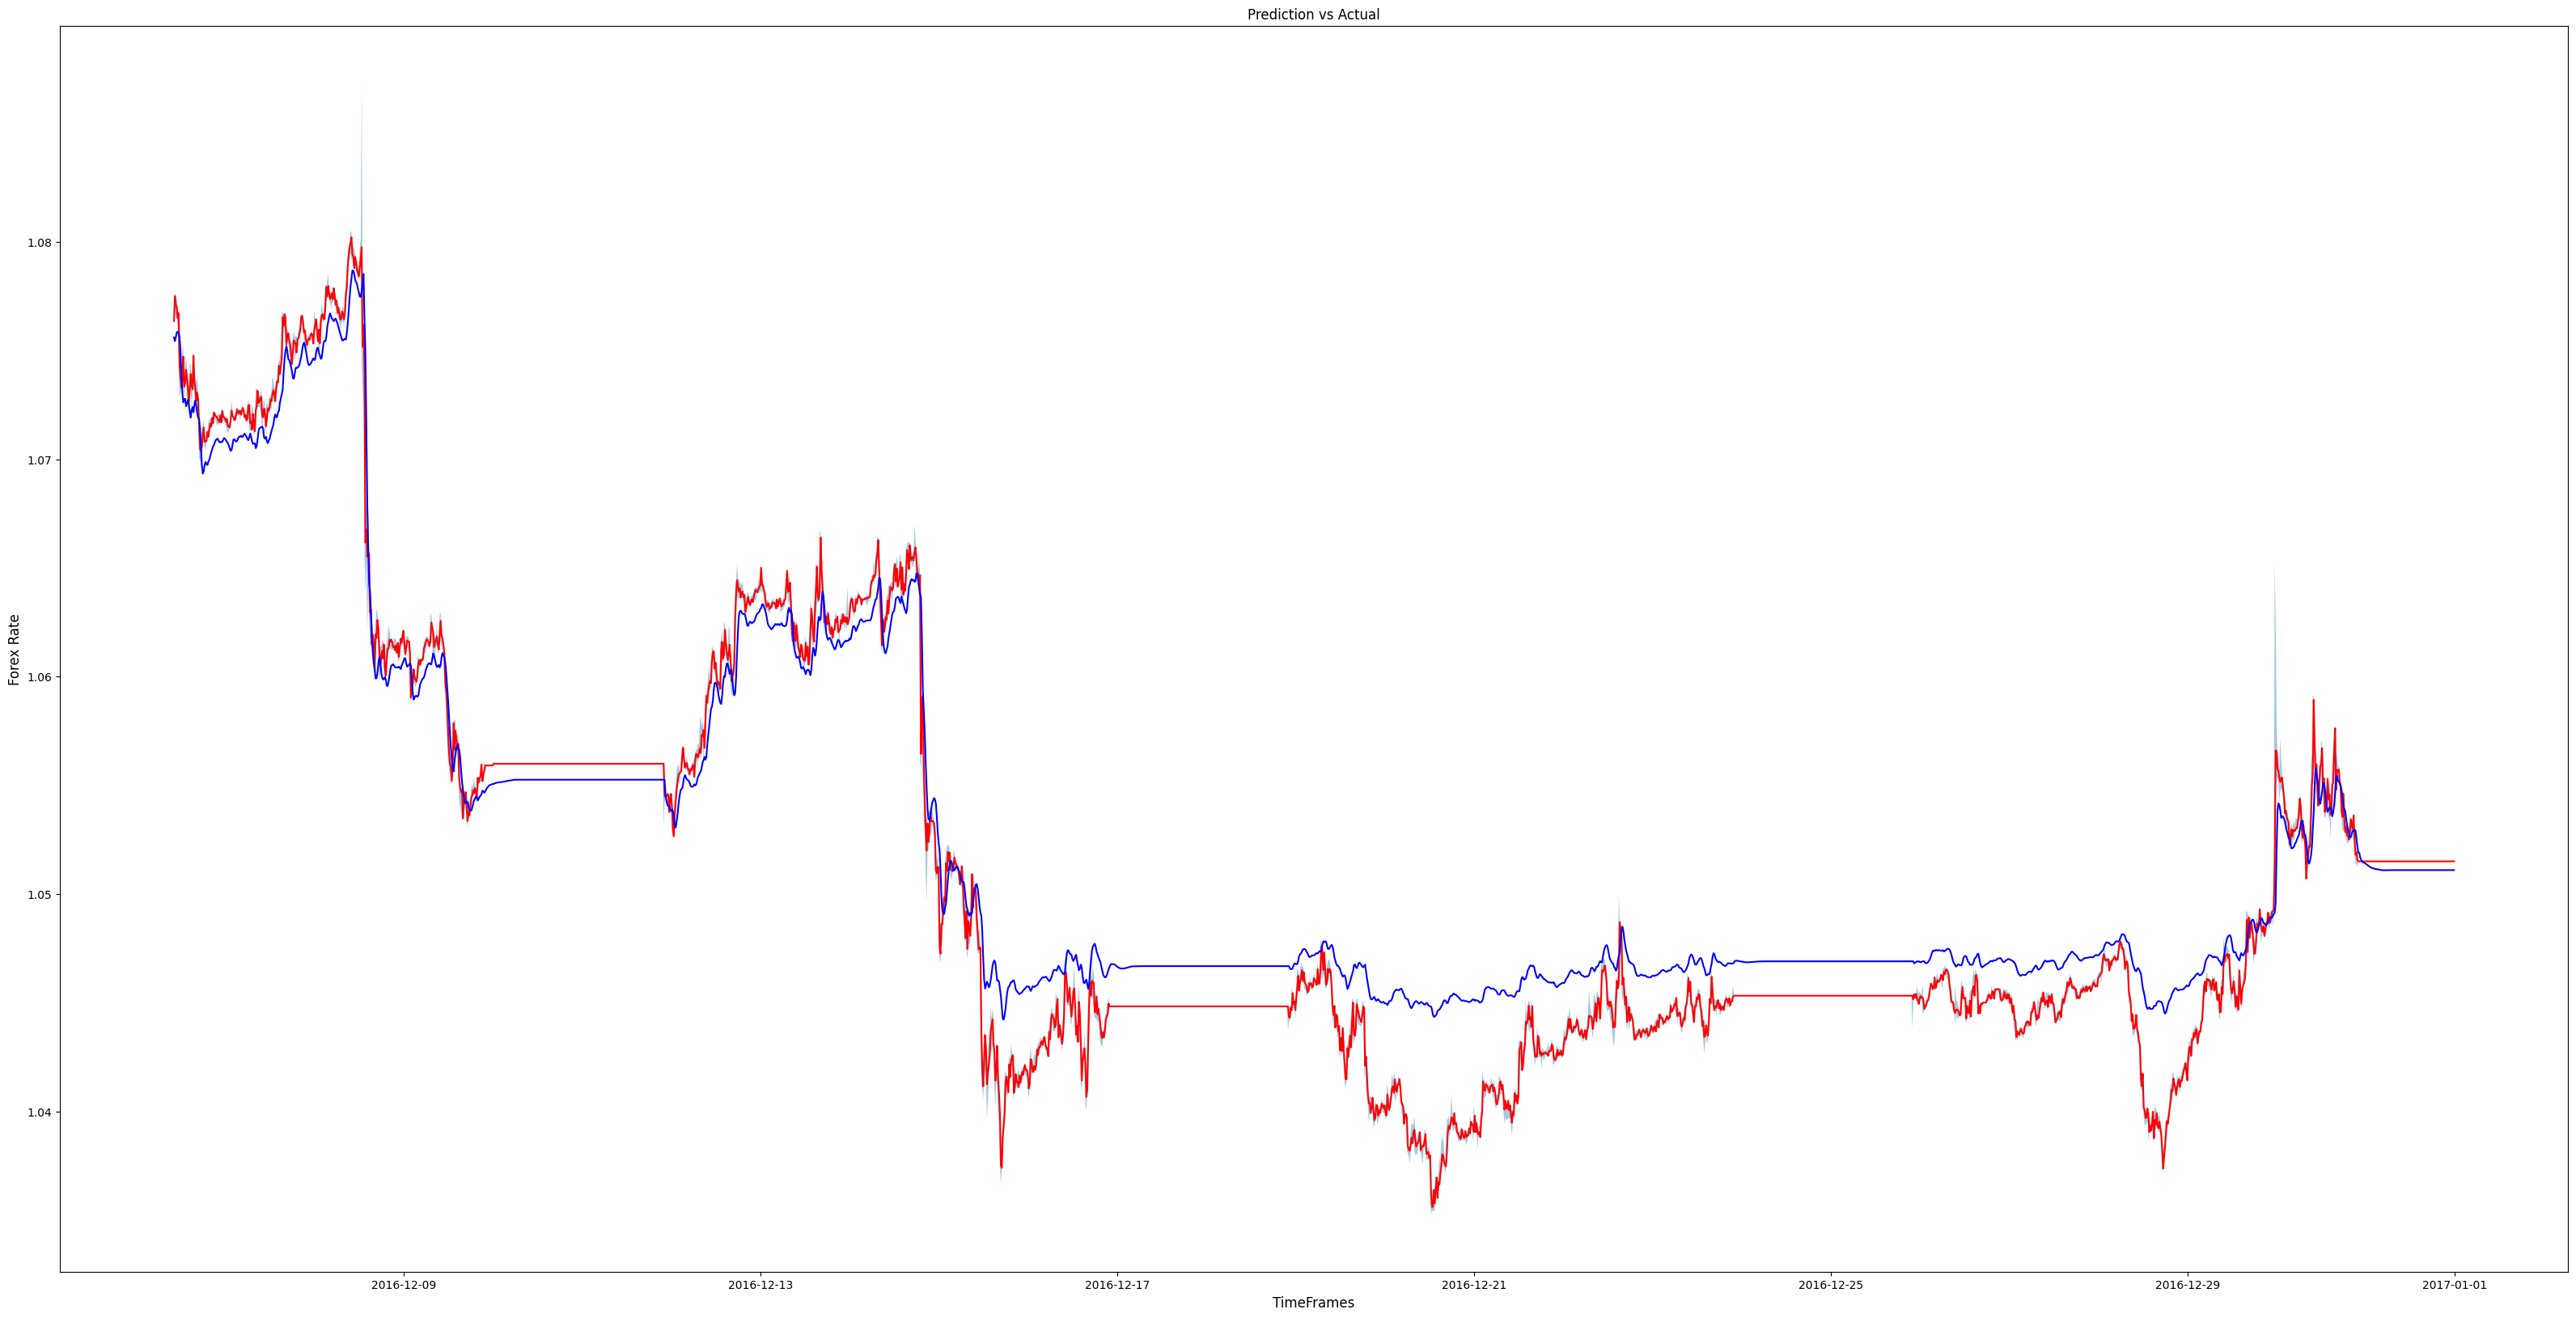

<ipython-input-13-c08e35ac4df1>:39: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions['diff']);


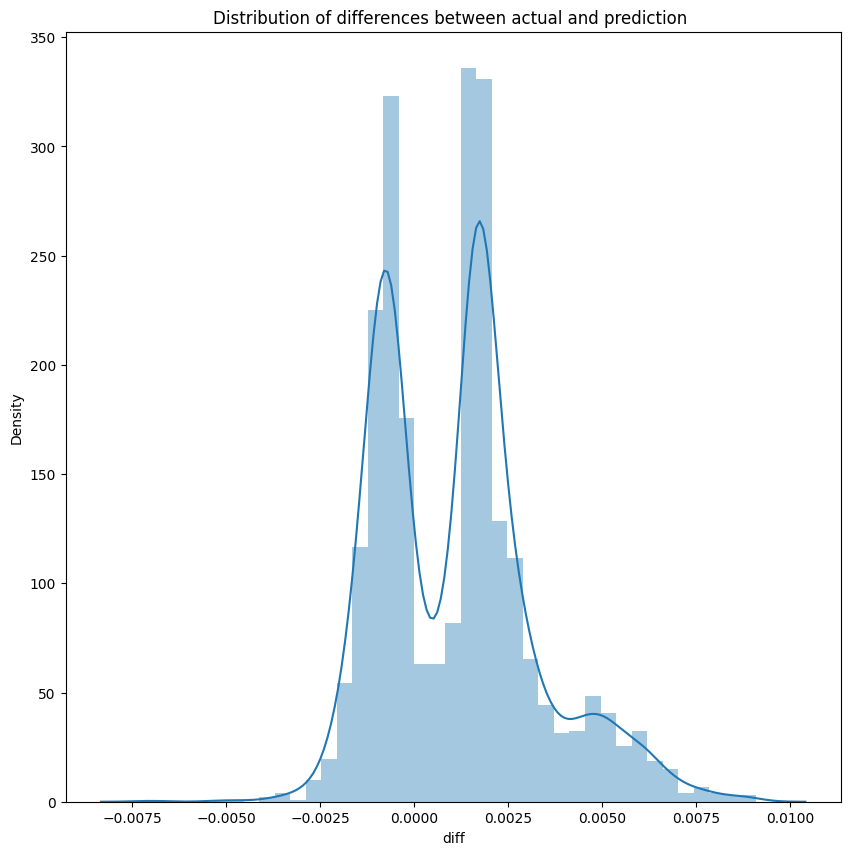

MSE :  5.704651457301518e-06
MAE :  0.001864092121784653


In [ ]:
import h5py
import numpy as np

def create_hdf5_file(file_path):
    # Create a new HDF5 file.
    with h5py.File(file_path, 'w') as f:
        # Create a dataset to store the weights.
        f.create_dataset('weight', shape=(10, 10), dtype='float32')

def save_weights_to_hdf5(file_path, weights):
    with h5py.File(file_path, 'a') as f:
        # Save the weights to the file.
        f['weight'][:] = weights

# File path for the HDF5 file
bi_rnn_weights = "/content/weights.best.hdf5"

# Create HDF5 file if it doesn't exist
create_hdf5_file(bi_rnn_weights)

# Use the weights for training
train()

# # Benchmark with the weights
benchmark()



77/77 [==============================] - 0s 5ms/step


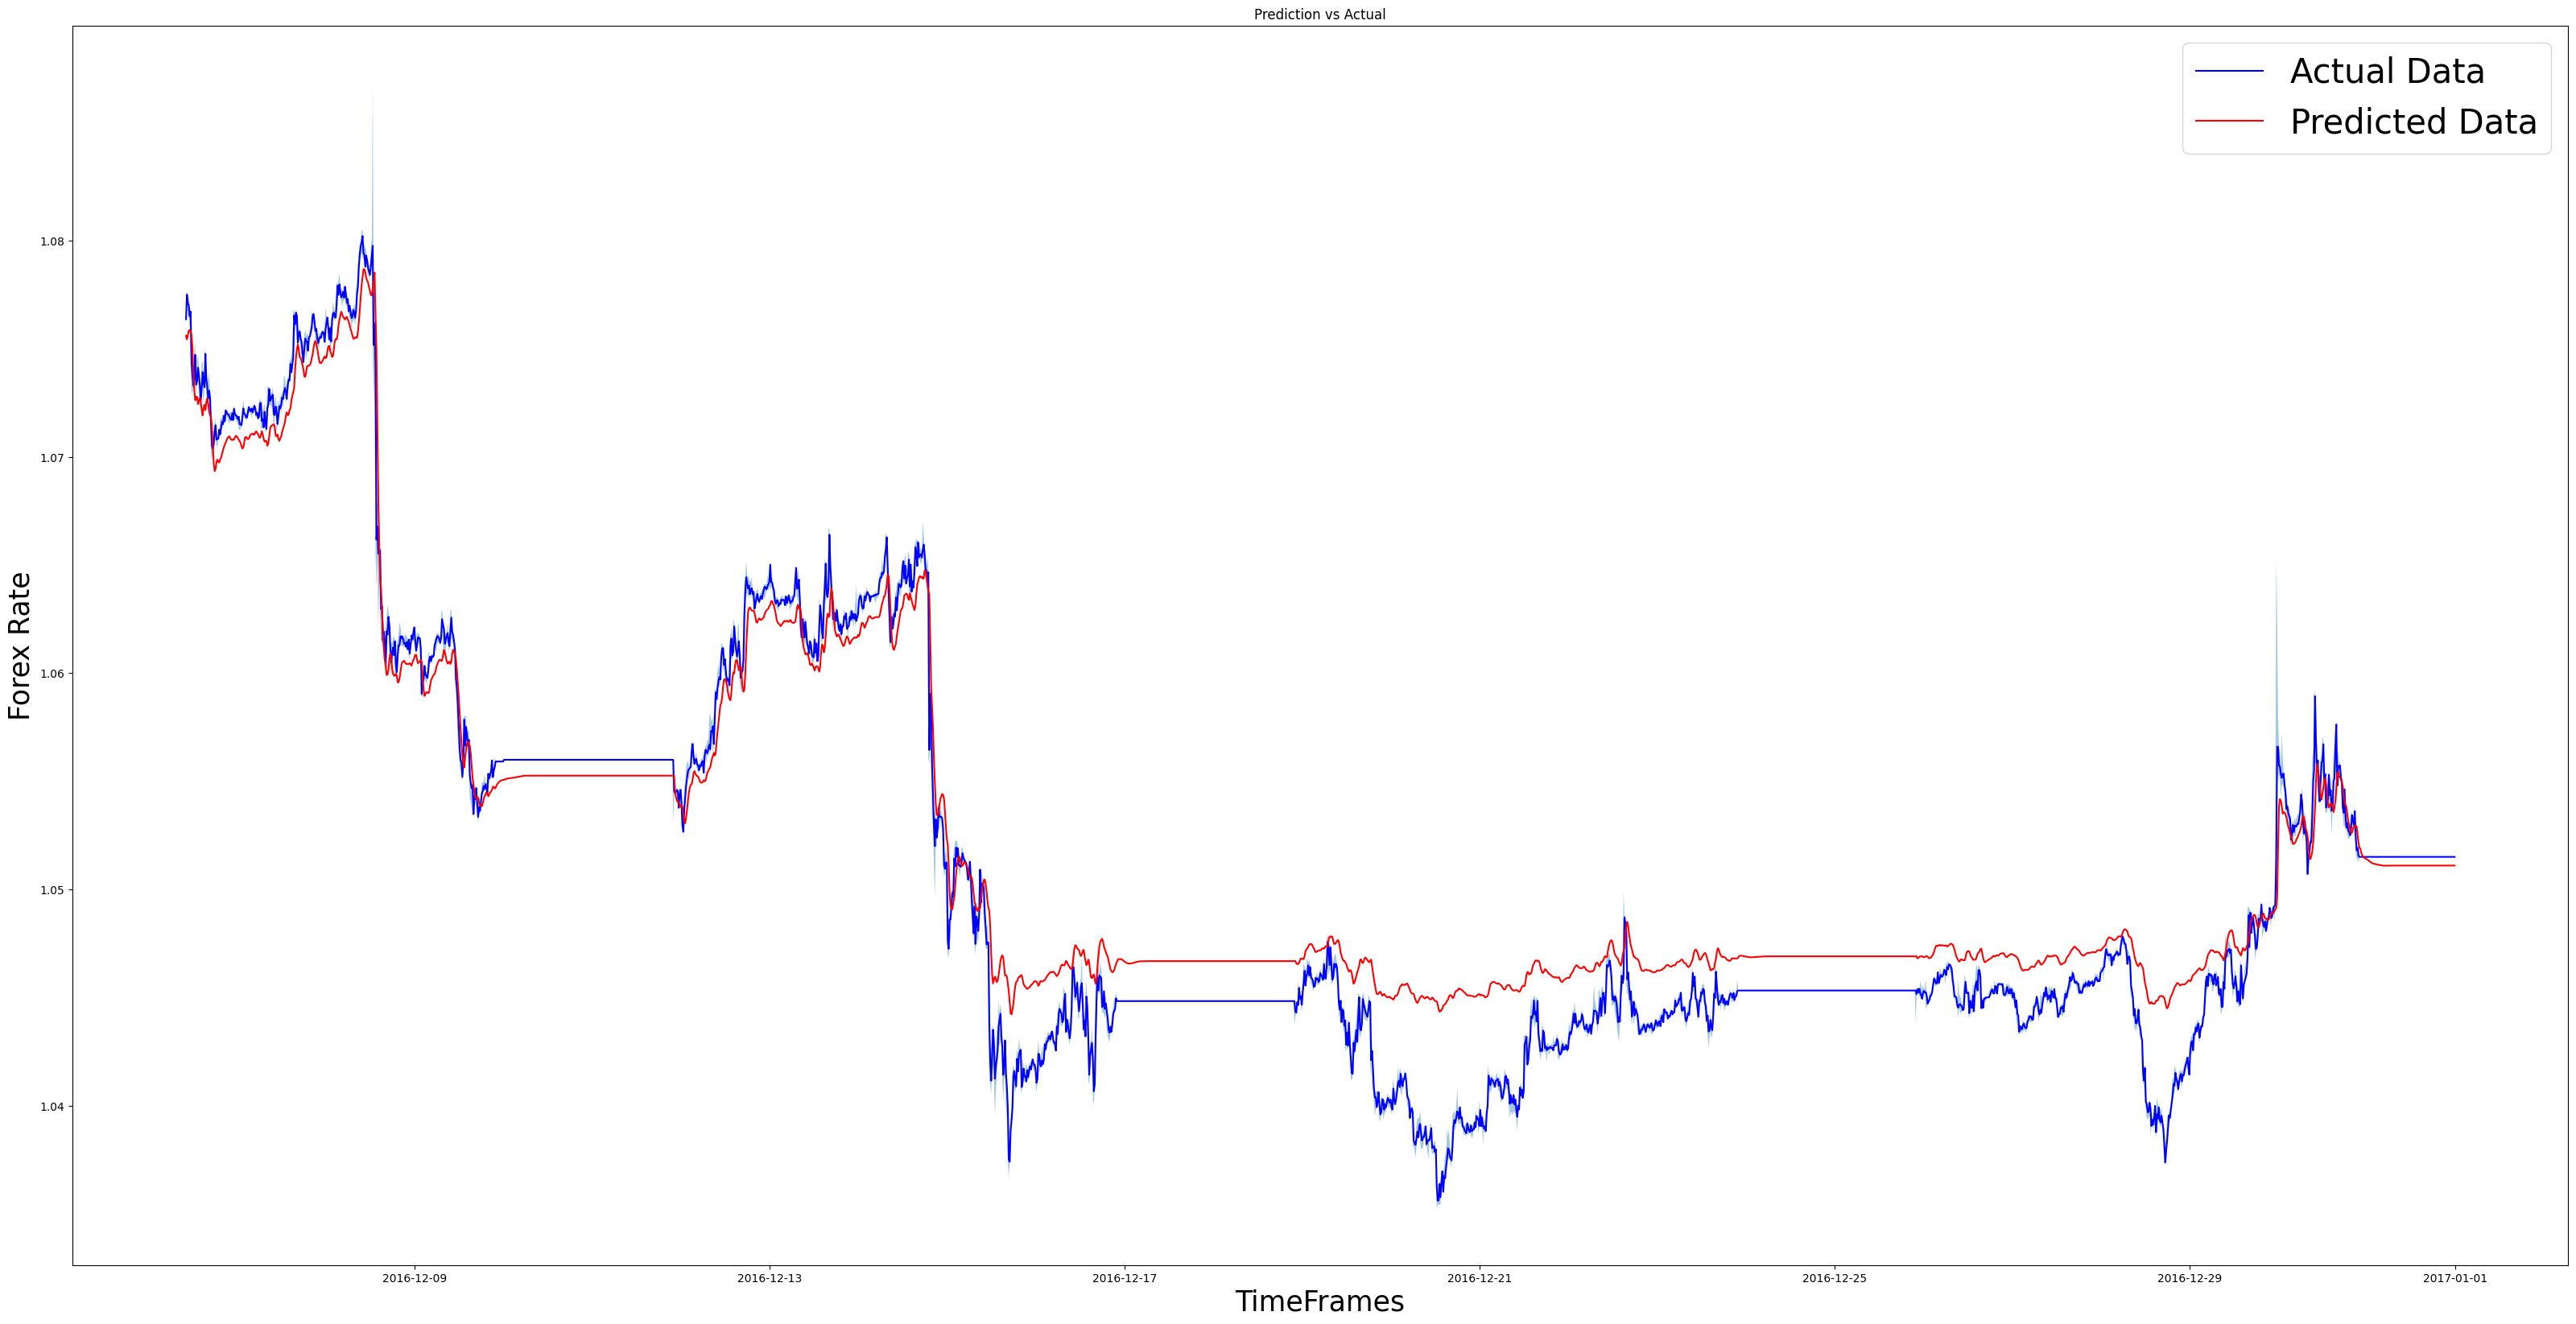

<ipython-input-23-98d68c4dd24f>:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions['diff']);


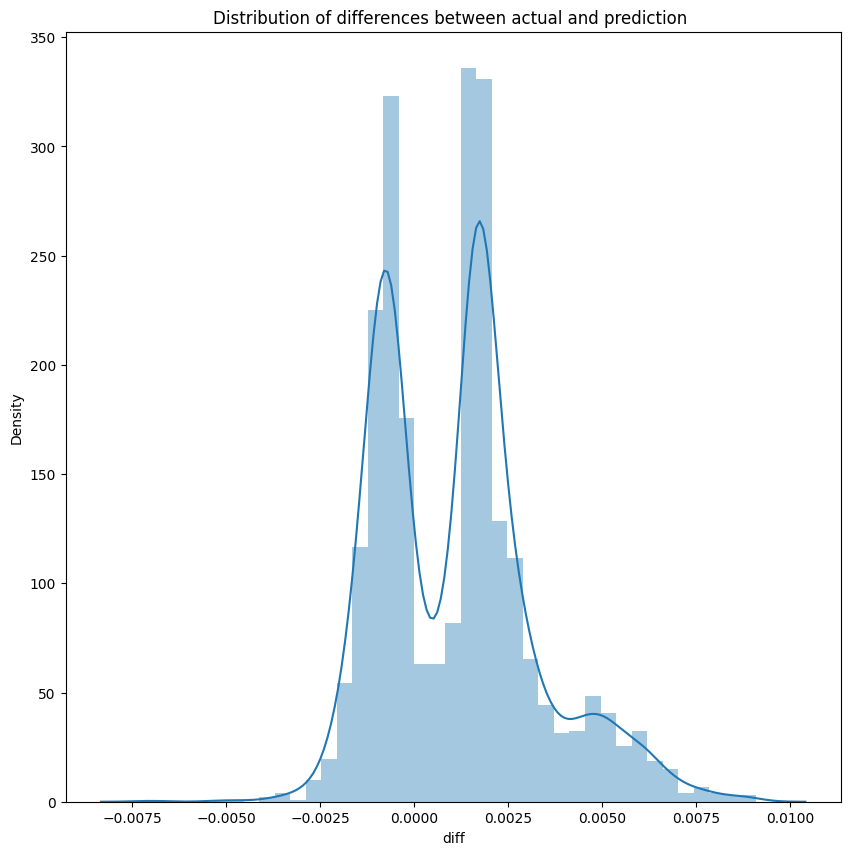

MSE :  5.704651457301518e-06
MAE :  0.001864092121784653


In [ ]:
# # Benchmark with the weights
benchmark()